In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.simplefilter(action='ignore')

# EDA

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
train_df = train_df.drop('id',axis=1)

test_df = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
test_df = test_df.drop('id',axis=1)

In [4]:
train_df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [6]:
train_df.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

# Work with missing data

In [8]:
train_df.isnull().sum() / train_df.shape[0]

brand           0.000000
model           0.000000
model_year      0.000000
milage          0.000000
fuel_type       0.026961
engine          0.000000
transmission    0.000000
ext_col         0.000000
int_col         0.000000
accident        0.013006
clean_title     0.113609
price           0.000000
dtype: float64

<Axes: xlabel='accident', ylabel='count'>

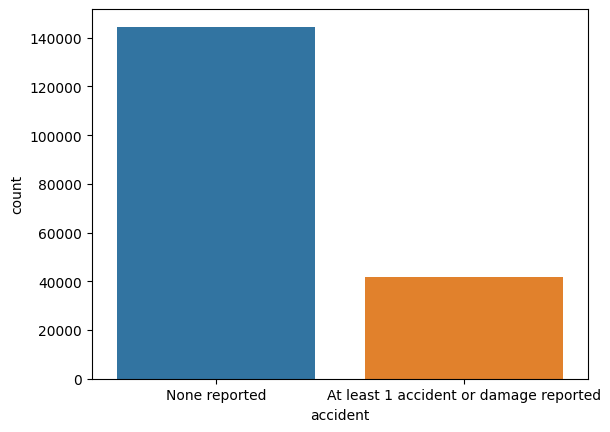

In [9]:
sns.countplot(data=train_df, x='accident')

<Axes: xlabel='clean_title', ylabel='count'>

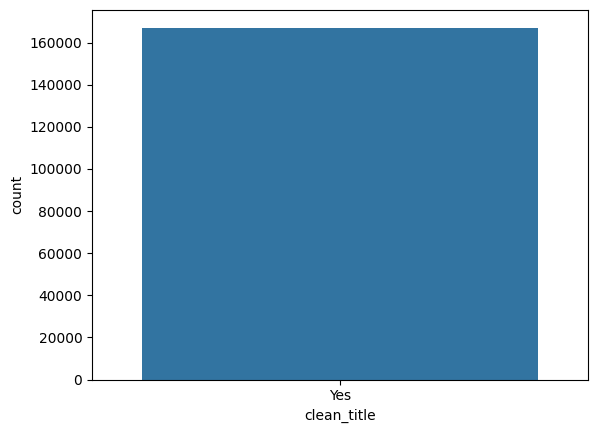

In [10]:
sns.countplot(data=train_df, x='clean_title')

<Axes: xlabel='fuel_type', ylabel='count'>

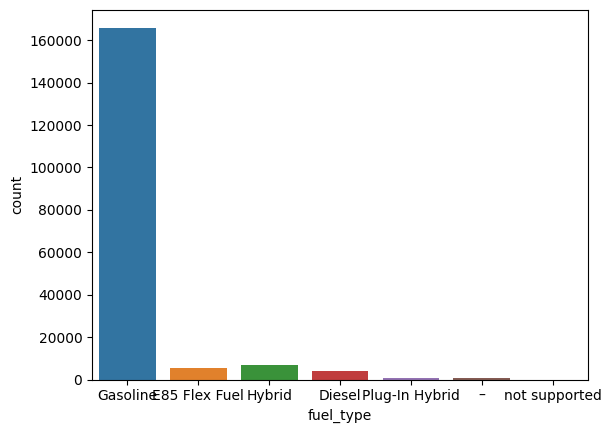

In [11]:
sns.countplot(data=train_df, x='fuel_type')

In [12]:
train_df['fuel_type'] = train_df.groupby('brand')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

train_df['accident'].fillna('None reported', inplace=True)

train_df.drop('clean_title',axis=1,inplace=True)

In [13]:
test_df['fuel_type'] = test_df.groupby('brand')['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

test_df['accident'].fillna('None reported', inplace=True)

test_df.drop('clean_title',axis=1,inplace=True)

In [14]:
train_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

In [15]:
test_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
dtype: int64

# Work with outliers

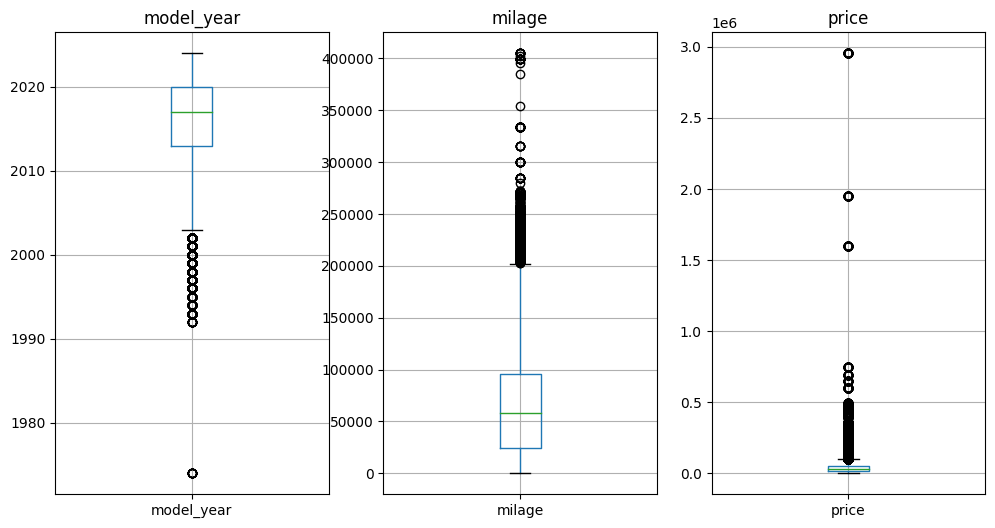

In [16]:
n_features = 3
n_cols = 3
n_rows = np.ceil(n_features/n_cols).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 6))
for i, feature in enumerate(train_df.describe()):
    train_df[[feature]].boxplot(ax=ax[i])
    ax[i].set_title(feature)

In [17]:
Q1 = train_df['milage'].quantile(0.25)
Q3 = train_df['milage'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
lower_array = np.where(train_df['milage'] <= lower)[0]
upper_array = np.where(train_df['milage'] >= upper)[0]

train_df.drop(index=lower_array, inplace=True)
train_df.drop(index=upper_array, inplace=True)

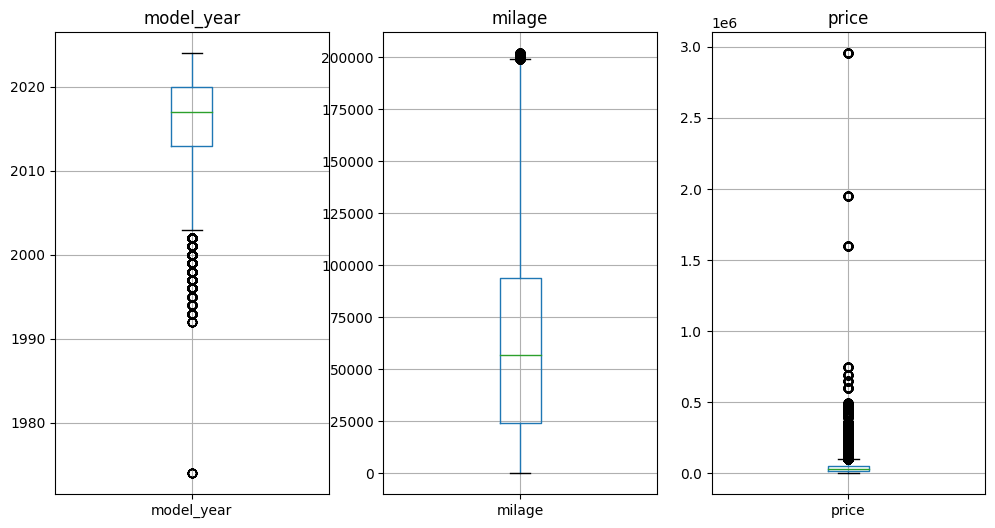

In [18]:
n_features = 3
n_cols = 3
n_rows = np.ceil(n_features/n_cols).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 6))
for i, feature in enumerate(train_df.describe()):
    train_df[[feature]].boxplot(ax=ax[i])
    ax[i].set_title(feature)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186767 entries, 1 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         186767 non-null  object
 1   model         186767 non-null  object
 2   model_year    186767 non-null  int64 
 3   milage        186767 non-null  int64 
 4   fuel_type     186767 non-null  object
 5   engine        186767 non-null  object
 6   transmission  186767 non-null  object
 7   ext_col       186767 non-null  object
 8   int_col       186767 non-null  object
 9   accident      186767 non-null  object
 10  price         186767 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 17.1+ MB


In [20]:
threshold=100
for col in train_df.select_dtypes('object').columns:
    train_df.loc[train_df[col].value_counts(dropna=False)[train_df[col]].values < threshold, col] = "noise"
    test_df.loc[test_df[col].value_counts(dropna=False)[test_df[col]].values < threshold, col] = "noise"

# Prepare Data

In [21]:
X = train_df.drop('price',axis=1)
y = train_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
def make_prediction(model):
    preds = model.predict(X_test)
    print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds))}')

# Cat Boost

In [24]:
n_estimators_range = np.array([500, 600, 700])
learning_rate_range = np.linspace(0.1, 1.0, 3).astype('float')
depth_range = np.array([3, 4, 5])
l2_leaf_reg_range = np.array([3, 4, 5])
bagging_temperature_range = np.linspace(0.1, 1.0, 3).astype('float')

In [31]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', n_estimators_range)
    learning_rate = trial.suggest_categorical('learning_rate', learning_rate_range)
    depth = trial.suggest_categorical('depth', depth_range)
    l2_leaf_reg = trial.suggest_categorical('l2_leaf_reg', l2_leaf_reg_range)
    bagging_temperature = trial.suggest_categorical('bagging_temperature', bagging_temperature_range)
    
    model = CatBoostRegressor(task_type = 'GPU', 
                              cat_features = np.array(train_df.select_dtypes(include='object').columns),
                              n_estimators = n_estimators,
                              learning_rate = learning_rate,
                              depth = depth,
                              l2_leaf_reg = l2_leaf_reg,
                              bagging_temperature = bagging_temperature,
                              verbose = 0)
    
    model.fit(X_train, y_train, eval_set = (X_test, y_test), early_stopping_rounds = 50, verbose = 0)
    
    y_pred = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    
    return rmse

In [32]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)

[I 2024-09-18 16:30:46,449] A new study created in memory with name: no-name-6234537d-28d8-4dd3-9d64-66927aec35ca
[I 2024-09-18 16:30:49,784] Trial 0 finished with value: 60319.192066063406 and parameters: {'n_estimators': 500, 'learning_rate': 0.55, 'depth': 4, 'l2_leaf_reg': 5, 'bagging_temperature': 0.1}. Best is trial 0 with value: 60319.192066063406.
[I 2024-09-18 16:30:56,909] Trial 1 finished with value: 60159.06796816561 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 3, 'bagging_temperature': 0.1}. Best is trial 1 with value: 60159.06796816561.
[I 2024-09-18 16:31:03,715] Trial 2 finished with value: 60159.06796816561 and parameters: {'n_estimators': 600, 'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 3, 'bagging_temperature': 0.1}. Best is trial 1 with value: 60159.06796816561.
[I 2024-09-18 16:31:11,484] Trial 3 finished with value: 60208.803091459304 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg

In [35]:
best_params = study.best_trial.params

In [36]:
best_cat_model = CatBoostRegressor(
    cat_features=np.array(train_df.select_dtypes(include='object').columns),
    task_type='GPU',  
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    bagging_temperature=best_params['bagging_temperature'],
    verbose=0)

In [37]:
best_cat_model.fit(X, y)

# Submission

In [38]:
answers = best_cat_model.predict(test_df)

In [41]:
submission_csv = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

In [42]:
(pd.DataFrame({'id': submission_csv['id'], 'price': answers})).to_csv('submission.csv', index=False)